## Tweet Sentiment Analysis using tweet

####1.  Tried to implement Naive Bayse first as base line to classification got 71% F1-Score
####2. second applied hyperparamter tunning for Naive Bayse
####3. Random forect model & Hyperparameter tunning for it got 65% F1 Score
####4. Applied LSTM with embeding using OneHot encoding accuracy 72%
####5. LSTM with word2vec & embeding w/o trainable 67% Accuracy
####6. LSTM with word2vec & embeding with trainable 78% Accuracy
####7. LSTM Bi-directional Accuracy 80% (crashed multiple time)

In [2]:
import pandas as pd

In [3]:
df=pd.read_csv('/content/tweet_data.csv')

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Removing punctuations
data=df.copy() #updated train to df
data = data.drop(['id','keyword','location'], axis = 1)
# Remove special characters; . , ! ? # @ -
data['text'].replace("[^a-zA-Z]"," ",regex=True, inplace=True)

In [5]:
data.head(1)

,text,target
0,Our Deeds are the Reason of this earthquake M...,1


In [6]:
data['text'].str.lower()

0       our deeds are the reason of this  earthquake m...
1                  forest fire near la ronge sask  canada
2       all residents asked to  shelter in place  are ...
3              people receive  wildfires evacuation or...
4       just got sent this photo from ruby  alaska as ...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609     aria ahrary  thetawniest the out of control w...
7610    m            utc   km s of volcano hawaii  htt...
7611    police investigating after an e bike collided ...
7612    the latest  more homes razed by northern calif...
Name: text, Length: 7613, dtype: object

In [7]:
headlines = []
for i in range(len(data['text'])):
  headlines.append(data['text'][i].lower())
headlines[0]

'our deeds are the reason of this  earthquake may allah forgive us all'

In [8]:
text = ' '.join(headlines)

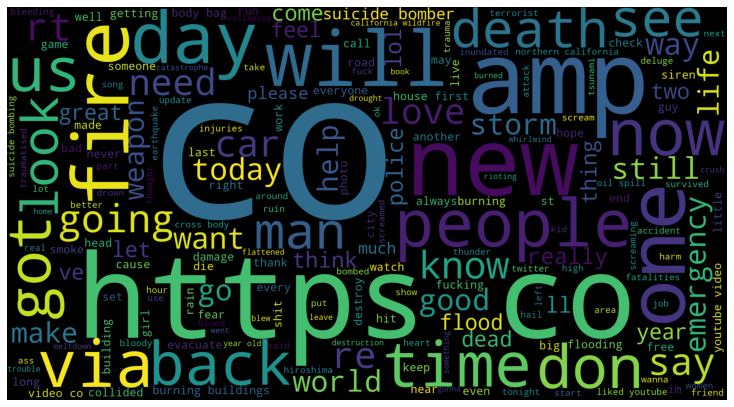

In [9]:
# Create WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
wordcloud = WordCloud(width=1980, height=1080).generate(text)
fig =  plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(wordcloud)
plt.tight_layout(pad=0)

More frequent word will shown as bigger than others like density plot

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [11]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpuss = []
for i in range(0, len(headlines)):
    #print(i)
    review = re.sub('[^a-zA-Z]', ' ', headlines[i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpuss.append(review)  

In [16]:
## implement BAG OF WORDS without stemming
countvector=CountVectorizer(ngram_range=(2,2))
traindataset=countvector.fit_transform(headlines[:5329])
train_label = df['target'][:5329]

In [17]:
## implement BAG OF WORDS with stemming & removing stop words
countvector_stm=CountVectorizer(ngram_range=(2,2))
stem_traindataset=countvector_stm.fit_transform(corpuss[:5329])
train_label = df['target'][:5329]

In [18]:
#Test data without stemming
test_dataset = countvector.transform(headlines[5330:])
test_label = df['target'][5330:]

In [19]:
#Test data with stemming
stem_test_dataset = countvector_stm.transform(corpuss[5330:])
test_label = df['target'][5330:]

# First Apply Naive Bayse model

In [20]:
naive = MultinomialNB()
naive.fit(traindataset,train_label)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [21]:
## Predict for the Test Dataset
pred_NB = naive.predict(test_dataset)

In [22]:
## Model performance
matrix_NB=confusion_matrix(test_label,pred_NB)
print(matrix_NB)
score_NB=accuracy_score(test_label,pred_NB)
print(score_NB)
report_NB=classification_report(test_label,pred_NB)
print(report_NB)

[[1016  258]
 [ 403  606]]
0.7104686815593517
              precision    recall  f1-score   support

           0       0.72      0.80      0.75      1274
           1       0.70      0.60      0.65      1009

    accuracy                           0.71      2283
   macro avg       0.71      0.70      0.70      2283
weighted avg       0.71      0.71      0.71      2283



In [23]:
nb_stem = naive.fit(stem_traindataset,train_label)

In [24]:
## Predict for the Test Dataset
pred_NBSTM = nb_stem.predict(stem_test_dataset)

In [25]:
## Model performance
matrix_NB=confusion_matrix(test_label,pred_NBSTM)
print(matrix_NB)
score_NB=accuracy_score(test_label,pred_NBSTM)
print(score_NB)
report_NB=classification_report(test_label,pred_NBSTM)
print(report_NB)

[[1063  211]
 [ 491  518]]
0.6925098554533509
              precision    recall  f1-score   support

           0       0.68      0.83      0.75      1274
           1       0.71      0.51      0.60      1009

    accuracy                           0.69      2283
   macro avg       0.70      0.67      0.67      2283
weighted avg       0.70      0.69      0.68      2283



### With stemming & removing stop words it reduces the score from model

# Apply Naive Bayse with Hyperparameter tunning

In [26]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, traindataset, train_label, scoring="roc_auc", cv=kf)

    return auc.mean()

The MultinominalNB class only have one hypterparameter - alpha. The code below will help us find the alpha value that gives us the highest CV AUC score.

Best alpha:  1.1


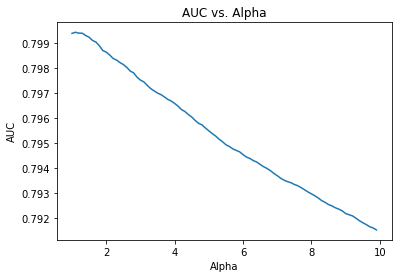

In [28]:
import numpy as np
res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [29]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.1)
nb_model.fit(traindataset, train_label)
pred_nb = nb_model.predict(test_dataset)


In [30]:
## Model performance
matrix_NB=confusion_matrix(test_label,pred_nb)
print(matrix_NB)
score_NB=accuracy_score(test_label,pred_nb)
print(score_NB)
report_NB=classification_report(test_label,pred_nb)
print(report_NB)

[[1017  257]
 [ 402  607]]
0.7113447218572054
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1274
           1       0.70      0.60      0.65      1009

    accuracy                           0.71      2283
   macro avg       0.71      0.70      0.70      2283
weighted avg       0.71      0.71      0.71      2283



We are already getting same performance from base model (because alpha are close)

# Apply RandomForest

In [31]:
rf = RandomForestClassifier()
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [32]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, None], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 2, verbose=2, random_state=42, n_jobs = 8)
# Fit the random search model
rf_random.fit(traindataset,train_label)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   25.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  3.7min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    score=accuracy_score(test_labels,predictions)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Score = {:0.2f}%.'.format(score))
    
    return score

In [34]:
## Import library to check accuracy
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


In [35]:
base_model = RandomForestClassifier(n_estimators = 500, max_depth=None, random_state = 42)
base_model.fit(traindataset,train_label)
base_accuracy = evaluate(base_model, test_dataset, test_label)


Model Performance
Average Error: 0.3824 degrees.
Score = 0.62%.


In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_dataset, test_label)

Model Performance
Average Error: 0.3482 degrees.
Score = 0.65%.


# Final to get output

In [36]:
# Function to get prediction from model
def tweet_analyze(txt, model):
  txt = re.sub('[^a-zA-Z]', ' ', txt)
  txt = [txt.lower()]
  txt = countvector.transform(txt)

  tt_pred = model.predict(txt)
  return ["There is risky situation" if tt_pred == 1 else "There is normal situation" ]


In [38]:
tweet_analyze('There is fire in mall', base_model)

['There is risky situation']

# Apply LSTM Over this

In [13]:
import tensorflow as tf

In [14]:
print(tf.__version__)

2.5.0


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import gensim


In [16]:
df['text'].shape

(7613,)

In [17]:
dff=pd.DataFrame(data['text'])
dff.head(1)

,text
0,Our Deeds are the Reason of this earthquake M...


In [18]:
### Vocabulary size
voc_size=5000

In [19]:
messages = dff.copy()

In [20]:
messages['text'][0]

'Our Deeds are the Reason of this  earthquake May ALLAH Forgive us all'

In [21]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    #print(i)
    review = re.sub('[^a-zA-Z]', ' ', messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

# One hot representation

In [48]:
from tensorflow.keras.preprocessing.text import one_hot
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr

[[168, 4375, 2051, 3939, 71, 3970, 2277],
 [2575, 2525, 4153, 2537, 2833, 238, 802],
 [2678, 147, 4714, 4048, 4025, 138, 3042, 4714, 4048, 242, 3496],
 [3630, 1857, 1294, 3042, 242, 2515],
 [348, 372, 44, 4365, 806, 3896, 1294, 2822, 2297],
 [4436, 3875, 2515, 1848, 601, 2471, 3494, 1229, 2925, 2525, 2717, 1294],
 [4837, 255, 4767, 3156, 213, 2908, 4837, 4321, 2000, 4924, 4179, 920],
 [4825, 2041, 4860, 2525, 268],
 [3818, 3042, 228, 928, 4974, 4321],
 [1725, 2515, 4226, 920],
 [4085, 3630, 361, 581, 2769, 1984],
 [4132,
  4431,
  4413,
  875,
  4837,
  4717,
  353,
  877,
  3749,
  4431,
  4413,
  4998,
  4998,
  2118,
  4837],
 [3156, 4837, 1156, 3548, 4413, 4678, 1579, 872],
 [4837, 3636, 1660, 1163, 3636],
 [4999, 2297, 80, 504, 4956, 3117, 3999],
 [2692],
 [3172, 4527],
 [1120, 3172],
 [4956, 48],
 [2940],
 [734],
 [2642, 4348],
 [3172, 2929],
 [730, 4678],
 [2289],
 [1076, 4981, 3913],
 [2951, 574, 4272],
 [3172, 1904],
 [3902],
 [1248, 872],
 [4907],
 [1985, 4248, 1207, 4235, 39

# Embeding representation

In [49]:
sent_length=100
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ...   71 3970 2277]
 [   0    0    0 ... 2833  238  802]
 [   0    0    0 ... 4048  242 3496]
 ...
 [   0    0    0 ... 4608 3143 1139]
 [   0    0    0 ... 2777 3638 1393]
 [   0    0    0 ... 4608 2229 1055]]


In [50]:
## Creating model
embedding_vector_features=64
model0=Sequential()
model0.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model0.add(LSTM(128))
model0.add(Dense(1,activation='sigmoid'))
model0.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model0.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 418,945
Trainable params: 418,945
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
import numpy as np
y = df['target']
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [52]:
X_final.shape, y.shape

((7613, 100), (7613,))

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Model Training

In [54]:
### Finally Training
hystory0 = model0.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
80/80 [==============================] - 9s 20ms/step - loss: 0.6069 - accuracy: 0.6653 - val_loss: 0.4738 - val_accuracy: 0.7851
Epoch 2/10
80/80 [==============================] - 1s 14ms/step - loss: 0.3821 - accuracy: 0.8367 - val_loss: 0.5159 - val_accuracy: 0.7537
Epoch 3/10
80/80 [==============================] - 1s 13ms/step - loss: 0.2734 - accuracy: 0.8916 - val_loss: 0.5540 - val_accuracy: 0.7604
Epoch 4/10
80/80 [==============================] - 1s 13ms/step - loss: 0.2043 - accuracy: 0.9245 - val_loss: 0.5998 - val_accuracy: 0.7330
Epoch 5/10
80/80 [==============================] - 1s 13ms/step - loss: 0.1601 - accuracy: 0.9457 - val_loss: 0.8057 - val_accuracy: 0.7417
Epoch 6/10
80/80 [==============================] - 1s 13ms/step - loss: 0.1037 - accuracy: 0.9653 - val_loss: 0.9012 - val_accuracy: 0.7350
Epoch 7/10
80/80 [==============================] - 1s 13ms/step - loss: 0.0663 - accuracy: 0.9800 - val_loss: 1.0754 - val_accuracy: 0.7330
Epoch 8/10
80

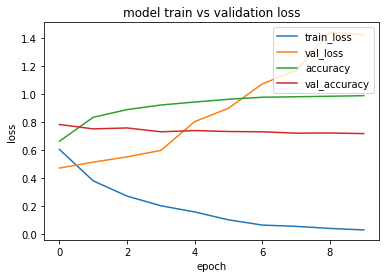

In [55]:
# plot train and validation loss
import matplotlib.pyplot as plt
plt.plot(hystory0.history['loss'])
plt.plot(hystory0.history['val_loss'])
plt.plot(hystory0.history['accuracy'])
plt.plot(hystory0.history['val_accuracy'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss','accuracy','val_accuracy'], loc='upper right')
plt.show()

# With Word2Vec Model with initial weight

In [22]:
data['text'] = data['text'].str.lower()
X = [d.split() for d in data['text'].tolist()]

In [23]:
train = pd.DataFrame(corpus)

In [24]:
train.columns = ['text']

In [25]:
train.head()

,text
0,deed reason earthquak may allah forgiv us
1,forest fire near la rong sask canada
2,resid ask shelter place notifi offic evacu she...
3,peopl receiv wildfir evacu order california
4,got sent photo rubi alaska smoke wildfir pour ...


In [26]:
X = [d.split() for d in train['text'].tolist()]

In [27]:
type(X)

list

In [28]:
#No of words in sentences
ln = 0
for i in range(len(X)):
  if len(X[i]) > ln:
    ln = len(X[i])
ln

27

In [29]:
print(X[0])

['deed', 'reason', 'earthquak', 'may', 'allah', 'forgiv', 'us']


In [26]:
X[:1]

[['deed', 'reason', 'earthquak', 'may', 'allah', 'forgiv', 'us']]

In [409]:
len(X)

7613

In [30]:
DIM = 30 # Dim higher than max words in sentence
wo2vec_model= gensim.models.Word2Vec(sentences =X, size = DIM, window = 5, min_count = 1)

In [90]:
len(wo2vec_model.wv.vocab)

18889

In [31]:
# Word closeness probability to the given word
wo2vec_model.wv.most_similar('fire')

[('amp', 0.9998029470443726),
 ('run', 0.9997981190681458),
 ('accid', 0.9997828006744385),
 ('live', 0.9997783899307251),
 ('world', 0.9997694492340088),
 ('evacu', 0.9997681379318237),
 ('even', 0.9997571706771851),
 ('go', 0.9997544884681702),
 ('back', 0.9997542500495911),
 ('citi', 0.9997498393058777)]

In [32]:
tokenizer = Tokenizer()

In [33]:
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [34]:
len(tokenizer.word_index)

18889

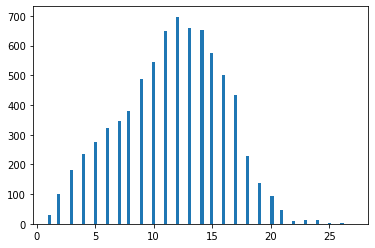

In [35]:
plt.hist([len(x) for x in X], bins = 100)
plt.show()

In [36]:
nos = np.array([len(x) for x in X])
len(nos[nos>15])

1485

In [37]:
max_len = 20000
X = pad_sequences(X, maxlen = max_len)

In [38]:
len(tokenizer.word_index)

18889

In [39]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [40]:
def get_weights_mat(model):
  weight_mat = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_mat[i] = model.wv[word]

  return weight_mat


In [41]:
embed_vec = get_weights_mat(wo2vec_model)

In [42]:
embed_vec.shape

(18890, 30)

In [43]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights= [embed_vec], input_length=max_len,trainable =False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])

In [436]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20000, 30)         566700    
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               81408     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 648,237
Trainable params: 81,537
Non-trainable params: 566,700
_________________________________________________________________


In [44]:
XX = np.array(X)
y = np.array(df["target"])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size = 0.3, random_state = 42)

In [46]:
len(X_train[0])

20000

In [47]:
y_train

array([0, 1, 1, ..., 0, 1, 1])

In [475]:
hystory = model.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=10, batch_size=64)

Epoch 1/10
84/84 [==============================] - 81s 948ms/step - loss: 0.6619 - accuracy: 0.6136 - val_loss: 0.6494 - val_accuracy: 0.6020
Epoch 2/10
84/84 [==============================] - 79s 939ms/step - loss: 0.6484 - accuracy: 0.6232 - val_loss: 0.6364 - val_accuracy: 0.6489
Epoch 3/10
84/84 [==============================] - 79s 944ms/step - loss: 0.6447 - accuracy: 0.6343 - val_loss: 0.6283 - val_accuracy: 0.6493
Epoch 4/10
84/84 [==============================] - 79s 943ms/step - loss: 0.6367 - accuracy: 0.6450 - val_loss: 0.6235 - val_accuracy: 0.6567
Epoch 5/10
84/84 [==============================] - 79s 944ms/step - loss: 0.6332 - accuracy: 0.6416 - val_loss: 0.6168 - val_accuracy: 0.6651
Epoch 6/10
84/84 [==============================] - 79s 944ms/step - loss: 0.6256 - accuracy: 0.6506 - val_loss: 0.6235 - val_accuracy: 0.6559
Epoch 7/10
84/84 [==============================] - 79s 945ms/step - loss: 0.6276 - accuracy: 0.6534 - val_loss: 0.6135 - val_accuracy: 0.6686

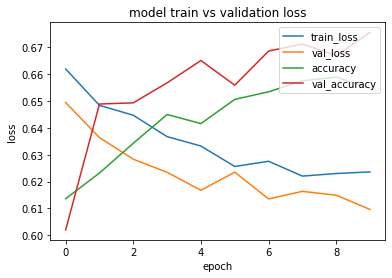

In [476]:
# plot train and validation loss
plt.plot(hystory.history['loss'])
plt.plot(hystory.history['val_loss'])
plt.plot(hystory.history['accuracy'])
plt.plot(hystory.history['val_accuracy'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss','accuracy','val_accuracy'], loc='upper right')
plt.show()

# Train using enabling trainable weights

In [48]:
model1 = Sequential()
#model.add(Embedding(vocab_size, output_dim=DIM, input_length=max_len,trainable =True))
model1.add(Embedding(vocab_size, output_dim=DIM, weights= [embed_vec], input_length=max_len,trainable =True))
model1.add(LSTM(units=128))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])

In [50]:
hystory1 = model1.fit(X_train,y_train,validation_data=(X_test,y_test), epochs=2, batch_size=64)

Epoch 1/2
84/84 [==============================] - 85s 1s/step - loss: 0.3394 - accuracy: 0.8557 - val_loss: 0.4374 - val_accuracy: 0.8113
Epoch 2/2
84/84 [==============================] - 84s 1s/step - loss: 0.2355 - accuracy: 0.9201 - val_loss: 0.4695 - val_accuracy: 0.7877


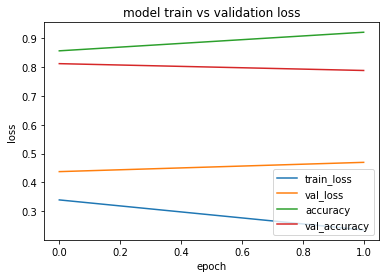

In [51]:
# plot train and validation loss
plt.plot(hystory1.history['loss'])
plt.plot(hystory1.history['val_loss'])
plt.plot(hystory1.history['accuracy'])
plt.plot(hystory1.history['val_accuracy'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss','accuracy','val_accuracy'], loc='lower right')
plt.show()

# Model performance

In [108]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [205]:
y_pred = model.predict_classes(X_test)
y_pred1 = model1.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [110]:
print("Model without trainable")
matrix=confusion_matrix(y_test,y_pred)
print(matrix)
score=accuracy_score(y_test,y_pred)
print(score)
report=classification_report(y_test,y_pred)
print(report)

Model without trainable
[[1061  257]
 [ 499  467]]
0.6690017513134852
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      1318
           1       0.65      0.48      0.55       966

    accuracy                           0.67      2284
   macro avg       0.66      0.64      0.64      2284
weighted avg       0.67      0.67      0.66      2284



In [206]:
print("Model with trainable")
matrix=confusion_matrix(y_test,y_pred1)
print(matrix)
score=accuracy_score(y_test,y_pred1)
print(score)
report=classification_report(y_test,y_pred1)
print(report)

Model with trainable
[[1201  117]
 [ 321  645]]
0.808231173380035
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1318
           1       0.85      0.67      0.75       966

    accuracy                           0.81      2284
   macro avg       0.82      0.79      0.80      2284
weighted avg       0.81      0.81      0.80      2284



#For testing model on inputs

In [59]:
# Function to get prediction from model
def tweet_LSTM(txt, LSmodel):
  txt = re.sub('[^a-zA-Z]', ' ', txt)
  txt = txt.lower()
  txt = txt.split()
    
  txt = [ps.stem(word) for word in test_sent if not word in stopwords.words('english')]
  txt = ' '.join(txt)
  txt = txt.split()
  txt = tokenizer.texts_to_sequences(txt)
  txt = pad_sequences(txt, maxlen = max_len)

  tt = LSmodel.predict_classes(txt)
  print(np.argmax(tt))
  return ["There is risky situation" if np.max(tt) == 1 else "There is normal situation" ]

In [60]:
tweet_LSTM('There was a fire & due to that many deaths happened', model2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


InternalError: ignored

#Apply Bidirectional LSTM

In [55]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

In [56]:
## Creating model
#embedding_vector_features=40
model2=Sequential()
model2.add(Embedding(vocab_size, output_dim=DIM, input_length=max_len))
model2.add(Bidirectional(LSTM(128)))
#model2.add(Dropout(0.2))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [57]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20000, 30)         566700    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               162816    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 729,773
Trainable params: 729,773
Non-trainable params: 0
_________________________________________________________________


In [58]:
### Finally Training
#model3.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10, batch_size=64)
hystory2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 4, batch_size = 64)

Epoch 1/4


CancelledError: ignored

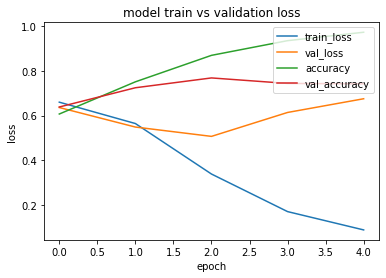

In [444]:
# plot train and validation loss
plt.plot(hystory2.history['loss'])
plt.plot(hystory2.history['val_loss'])
plt.plot(hystory2.history['accuracy'])
plt.plot(hystory2.history['val_accuracy'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss','accuracy','val_accuracy'], loc='upper right')
plt.show()